In [1]:
# -*- coding: utf-8 -*-
# based on https://danijar.com/variable-sequence-lengths-in-tensorflow/

import numpy as np
import random
import functools
import tensorflow as tf
import time
import re #regexp

from tensorflow.python.ops import rnn_cell, rnn
from sklearn.metrics import confusion_matrix #compute confusion_matrix
from matplotlib import pyplot as plt #display confusion_matrix

family = 'Object' 

directory = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/'
directory_dataset = directory + 'data_nathan/'

file_training = "training.txt"
file_testing = "testing.txt" 

feat_size = 63 #21 joints * 3 dimensions (xyz)

batch_size = 20
padding_size = 300

# Parameters
learning_rate = 0.003
n_epochs = 100

# Network Parameters
seq_max_len = padding_size # Sequence max length
n_hidden = 100 # hidden layer num of features
max_seq_l = 120

p_dropout = 0.2 #1 #0.8


/home/nathan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Extract action-to-group dictionary & group labels
def action_to_group (location, family):

    with open(location, 'r') as f:
        pattern = '_(\w+)' #for Object by default
        if family == 'Motion': pattern = '(\w+)_' #add patterns like this as a list
        regexp = re.compile(pattern)
        get = re.findall( regexp, f.read() )

    atog = list() #action to group dictionary 
    g_labels = list() 
    for i in get:
        #check if group already exists
        if i not in g_labels: #extract group number as index of word in submitted & add it to action group dictionary
            g_labels.append(i)
        atog.append( g_labels.index(i) ) 

    #num_g = len(g_labels) FYI
    
    return (atog, g_labels) 

def read_data(filename):
    # Reads file containing features and returns features indexed by time
    x = []
    tmp_length = 0
    with open(filename) as f:
        for line in f:
            numbers_str = line.split()
            nums_float = [float(a) for a in numbers_str]
            x.append(nums_float)
            tmp_length =tmp_length+1
            # print(len(x))
    # x.extend([[0.0]*feat_size]*(padding_size-len(x)+1))
    f.close() #necessary ? supposed to be automatic
    tmp_val = np.min([tmp_length-1,max_seq_l])
    #print(tmp_val)
    return x[1:]  # ignore de first line (num of frames)

def read_config(filename):
    # Reads config file and returns filenames and class label
    x = []
    with open(filename) as f:
        for line in f:
            line_split = line.split()
            x.append(line_split)
    f.close()
    return x

# one hot encoding
def num_to_idx(num, num_classes):
    vec = np.zeros( shape=num_classes, dtype=np.float) #hardcode here
    vec[num] = 1
    return vec

In [3]:
#Called once to load training/testing data in MODEL
def create_dataset(filename, atog, group_number):
    # dataset is organized as NxLxD (N = num samples, L temporal length with padding, D feature dimension
    # labels is NxY where Y is one hot label vector

    dataset, labels, lengths = [], [], []
    files = read_config(filename)
    
    if group_number == -2: #groupRNN to subnets
        pass
    elif group_number == -1: #main RNN
        num_classes = max(atog) + 1 # as labelled 0 to 25 but want 26 as number of classes
    else: #subnets
        gtoa = group_to_action(atog) 
        list_actions = gtoa[group_number] #gives list of actions in current group number
        num_classes = len(list_actions)
        
    for i in files:
        
        if group_number == -2: #Feed output of groupRNN to pre-trained subnet
            
            tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
            tmp_labels = int(i[1]) #will one hot out of here as first need to dispatch data to relevant subnet using labels
        
        elif group_number == -1: #Build group main RNN
            
            tmp_data = read_data(directory_dataset + i[0]) 
            num =  atog[ int( i[1] )] #only used for one hot encoding in the line below
            tmp_labels = np.transpose(num_to_idx(num, num_classes)) 
            #i[0] =  a01s01r01.txt (for eg)
            #i[1] = number between 0 and 44 (or as many classes there is)
            #tmp_labels = [0, 0, 1, 0, .. 0] = one-hot encoding of class value
            #tmp_data = list with variable len around 300 & each item in the list is a nested list of len 63 (=feat_size)
        
        else: #Build action subnet RNN 
            
            num = int( i[1] ) #original action number
            if num in list_actions: #select data only if belongs to group 
                tmp_data = read_data(directory_dataset + i[0]) #add to dataset if part of the group
                tmp_labels = np.transpose(num_to_idx(list_actions.index(num), num_classes)) #add labels as well     
            else: continue
            
        if len(tmp_data)<300: #why 300, is that the longest sequence ? 300 = padding_size btw...
            
            #records tmp_data initial length before padding
            #pads tmp_data with zeros until padding_size (300) so len(tmp_data) = 300 always with len 63 items
                
            lengths.append(len(tmp_data))
            tmp_data.extend([ [0.0] * feat_size ] * (padding_size - len(tmp_data)))  

            dataset.append(tmp_data)
            labels.append(tmp_labels) 
        
    # all 0..565 lists with item as nested lists of size (300, 26, 1)
    return dataset, labels, lengths

#Called once when training RNN
def batch_generation(data,labels,lengths):
    
    num_classes = np.size(labels,1) #labels is a one hot encoded numpy array. This returns number of columns (=groups).
    
    nsamples,_,_ = data.shape

    indices = np.arange(nsamples)
    np.random.shuffle(indices)
    num_batches = int(np.floor(nsamples/batch_size))
    not_exact = 0

    if nsamples%batch_size != 0:
        not_exact = 1

    batches_data = np.empty(shape=[num_batches+not_exact,batch_size,padding_size,feat_size])
    batches_labels = np.empty(shape=[num_batches+not_exact,batch_size,num_classes]) #hardcode here with num_classes
    batches_lengths = np.empty(shape=[num_batches + not_exact, batch_size],dtype=np.int32)

    for x in range(num_batches):
        batches_data[x, :, :, :] = data[indices[batch_size*x:batch_size*(x+1)], :, :]
        batches_labels[x,:,:] = labels[indices[batch_size*x:batch_size*(x+1)], :]
        batches_lengths[x,:] = lengths[indices[batch_size*x:batch_size*(x+1)]]

    if not_exact > 0:
        to_complete = nsamples%batch_size
        tmp_data = data[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:,:]
        tmp_random = np.random.randint(0,nsamples-to_complete,batch_size-to_complete) # we complete last batch with random samples

        batches_data[num_batches]=np.concatenate((tmp_data,data[tmp_random,:,:]),axis=0)

        tmp_labels = labels[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:]
        batches_labels[num_batches] = np.concatenate((tmp_labels,labels[indices[tmp_random],:]))
        tmp_lengths = lengths[indices[batch_size*num_batches:batch_size*num_batches+to_complete]]
        batches_lengths[num_batches] = np.concatenate((tmp_lengths,lengths[indices[tmp_random]]))

    return batches_data, batches_labels, batches_lengths, num_batches+not_exact

In [4]:
def dynamicRNN(x, seqlen, weights, biases, keep_prob):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, feat_size])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, seq_max_len, 0) # tf.split(value, num_or_size_splits, axis)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    
    #Operator adding dropout to inputs and outputs of the given cell.
    lstm = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob) 
    
    #Added to have 2 layers LSTM, not used here.
    layers = 1
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * layers)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32, sequence_length=seqlen)
    
    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e, if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

In [5]:
def doMyRNN(location, family, group_number):

    # ==========
    #   MODEL
    # ==========
    print('in MODEL')

    tf.reset_default_graph() #Clear computational graph to prevent error

    # Load training and testing data
    (atog, _) = action_to_group(location, family)
    train_data, train_labels, train_lengths = create_dataset(file_training, atog, group_number)
    test_data, test_labels, test_lengths = create_dataset(file_testing, atog, group_number)

    #cast to numpy array
    train_data = np.asarray(train_data)
    train_labels = np.asarray(train_labels)
    train_lengths = np.asarray(train_lengths,dtype=np.int32)
    test_data = np.asarray(test_data)
    test_labels = np.asarray(test_labels)
    test_lengths = np.asarray(test_lengths)

    (samples, rows, row_size) = train_data.shape

    n_classes = np.size(train_labels,1)

    # tf Graph input
    x = tf.placeholder("float", [None, seq_max_len, feat_size], name="x")
    y = tf.placeholder("float", [None, n_classes], name="y")

    # A placeholder for indicating each sequence length
    seqlen = tf.placeholder(tf.int32, [None], name="seqlen")

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

    # ==========
    #   LAUNCH
    # ==========
    print('in LAUNCH')

    pred = dynamicRNN(x, seqlen, weights, biases, keep_prob)

    # Evaluate model 
    prediction = tf.argmax(pred,axis=1, name="prediction") # for each prediction, keep class with highest level of confidence (tests X classes)
    correct_pred = tf.equal(prediction, tf.argmax(y,1)) #output 0 & 1 vector, y is supposed to have true labels
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) #mean of above

    #Create a saver object which will save all the variables
    #saver = tf.train.Saver()

    # ============
    #   OPTIMIZE
    # ============
    print('in OPTIMIZE')

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the graph
    with tf.Session() as sess:

        sess.run(init)

        max_acc = 0.0;
        max_epoch = 0;
        best_labels = []

        # Keep training until reach max iterations
        for epoch in range(n_epochs):

            (batch_x, batch_y, batch_seqlen, n_batches) = batch_generation(train_data, train_labels, train_lengths)

            start = time.time()

            for i in range(n_batches):

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x[i,:,:,:], y: batch_y[i,:,:],
                                               seqlen: batch_seqlen[i,:], keep_prob: p_dropout})

            # Test accuracy on this epoch    
            test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})

            #Save best testing results
            if test_acc > max_acc: 
                
                #Save the best accuracy and predictions
                max_acc = test_acc; max_epoch = epoch
                #gives the confidence score of every class at output along columns (dim 1)
                labels = pred.eval(feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
                # pred_labels = tf.argmax(labels, 1) OR
                pred_labels = prediction.eval(feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
                #test_labels is one_hot. Want 1-D like best_labels
                true_labels = np.asarray( [ np.where(r==1)[0][0] for r in test_labels ], dtype=np.int64)

                #Save best  
                saver = tf.train.Saver() #Create a saver object which will save all the variables
                location = directory + 'saved_sessions/subnets/' + family + '/subnet_' + str(group_number)
                saver.save(sess, location)
                print('Saved subnet at epoch ' + str(epoch) + ' at ' + location)

            print('Epoch {:2d} accuracy {:3.1f}% in {:3.1f} seconds'.format(epoch, 100 * test_acc, time.time() - start))
            print('max_acc {:3.1f}% at epoch {:2d} \n'.format(max_acc*100, max_epoch))
            
            #Stop training when accuracy is maximum
            if max_acc == 1: 
                print('Reached 100% accuracy -> exit training \n')
                break
             
        print ("Optimization Finished!")

        return (labels, pred_labels, true_labels)

        # ToDo
        # Get training accuracy and plot it along test accuracy 
        # Add a validation set accuracy to train without overfitting


In [6]:
#Display confusion matrix
def confusion_mtx(true, pred, name_labels):
    
    num_classes = len(name_labels)
    cm = confusion_matrix(true, pred)

    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(num_classes), name_labels, rotation=90)
    plt.yticks(range(num_classes), name_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    #TODO
    #Adjust the matrix scale (0 to 45 to the relevant scaling 0 to 100%)
    #Have a checkerboard figure to track classes easily
    #Have white background for better error reading for colorbar
    #Rotate 45 the vertical axis
    #Write number of successful matches inside the box (especially good for subnets)

#Display confidence level bar histogram 
def confidence_probability_g (scores, pred_class, true_class, g_labels):
    
    format_scores = scores - np.amin(scores)
    format_scores = format_scores / np.amax(format_scores)
    
    #y = scores
    y = format_scores #probabilities made from normalising on this 1 score (not on the 569 scores)
    x = range(len(scores)) #as much scores as there is in y (45)
    
    plt.figure(figsize=(20,4))
    
    barlist = plt.bar(x,y, width=0.7)

    import randomcolor
    colors = randomcolor.RandomColor().generate(count=len(g_labels)) #as many group or actions    
    for i in range(len(barlist)): barlist[i].set_color(colors[i])
    
    plt.title('Predicted class ' + str(pred_class) + ' ' + g_labels[pred_class] 
                 + ' for class ' + str(true_class) + ' ' + g_labels[true_class],
                 fontsize=18)
    
    plt.xticks(x, g_labels, rotation=90, fontsize=18)
    
    plt.show()
    
    #ToDo
    # Be able to know the name of sample seq that fails 

In [7]:
def get_group_labels(group_number):
    with open(directory + 'labels/name_of_labels_original.txt') as f:
        all_45_action_labels = [word for line in f for word in line.split()]
    action_labels_inside_this_group = [all_45_action_labels[i] for i in range(len(atog)) if atog[i] == group_number]
    return action_labels_inside_this_group

def group_to_action(atog):
    gtoa = []
    for group_number in range(max(atog)+1):
        gtoa.append( [index for index, value in enumerate(atog) if value == group_number] )
    return gtoa

**Execution - Group RNN **

In [ ]:
#Train group RNN on classifying the object group

#Load group dico and labels
location = directory + 'labels/grouping_1/object_group_labels.txt'

(labels, pred_labels, true_labels) = doMyRNN(location, family, -1) #-1 as this is a main group net (not subnet)

#Save on disk to not have to retrain to get results
location = directory + 'results/group_RNN/' + family + '/'
np.save(location + 'labels.npy', labels)    # .npy extension is added if not given
np.save(location + 'pred_labels.npy', pred_labels) 
np.save(location + 'true_labels.npy', true_labels) 

In [ ]:
#Analyze Object group RNN results

#Load variables to analyze
location = directory + 'results/group_RNN/' + family + '/'
(labels, pred_labels, true_labels) = ( np.load(location + 'labels.npy'), 
                                       np.load(location + 'pred_labels.npy'),
                                       np.load(location + 'true_labels.npy') )
location = directory + 'labels/grouping_1/object_group_labels.txt'
(_, g_labels) = action_to_group(location, family)

# Run analysis: score, accuracy, conf_mat
ite = 7
confidence_probability_g (labels[ite,:], pred_labels[ite], true_labels[ite], g_labels)
correct_pred = np.equal(true_labels, pred_labels) #output 0 & 1 vector
acc = np.mean(correct_pred) #mean of above
print('Group %s Accuracy %.2f %% with %i groups' % (family, float(100*acc), len(g_labels)))
confusion_mtx(true_labels, pred_labels, g_labels)

**Execution - Subnets RNN **

in MODEL
in LAUNCH
in OPTIMIZE


/home/nathan/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Saved subnet at epoch 0 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  0 accuracy 53.8% in 97.8 seconds
max_acc 53.8% at epoch  0 

Epoch  1 accuracy 48.7% in 0.7 seconds
max_acc 53.8% at epoch  0 

Epoch  2 accuracy 53.8% in 0.6 seconds
max_acc 53.8% at epoch  0 

Saved subnet at epoch 3 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  3 accuracy 66.7% in 8.7 seconds
max_acc 66.7% at epoch  3 

Epoch  4 accuracy 66.7% in 0.7 seconds
max_acc 66.7% at epoch  3 

Saved subnet at epoch 5 at /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
Epoch  5 accuracy 79.5% in 8.3 seconds
max_acc 79.5% at epoch  5 

Epoch  6 accuracy 76.9% in 0.8 seconds
max_acc 79.5% at epoch  5 

Epoch  7 accuracy 74.4% in 0.9 seconds
max_acc 79.5% at epoch  5 

Epoch  8 accuracy 79.5% in 0.8 seconds
max_acc 79.5% at epoch  5 

Epoch  9 accuracy 76.9% in 0.7 seconds
max_acc 79.5% a

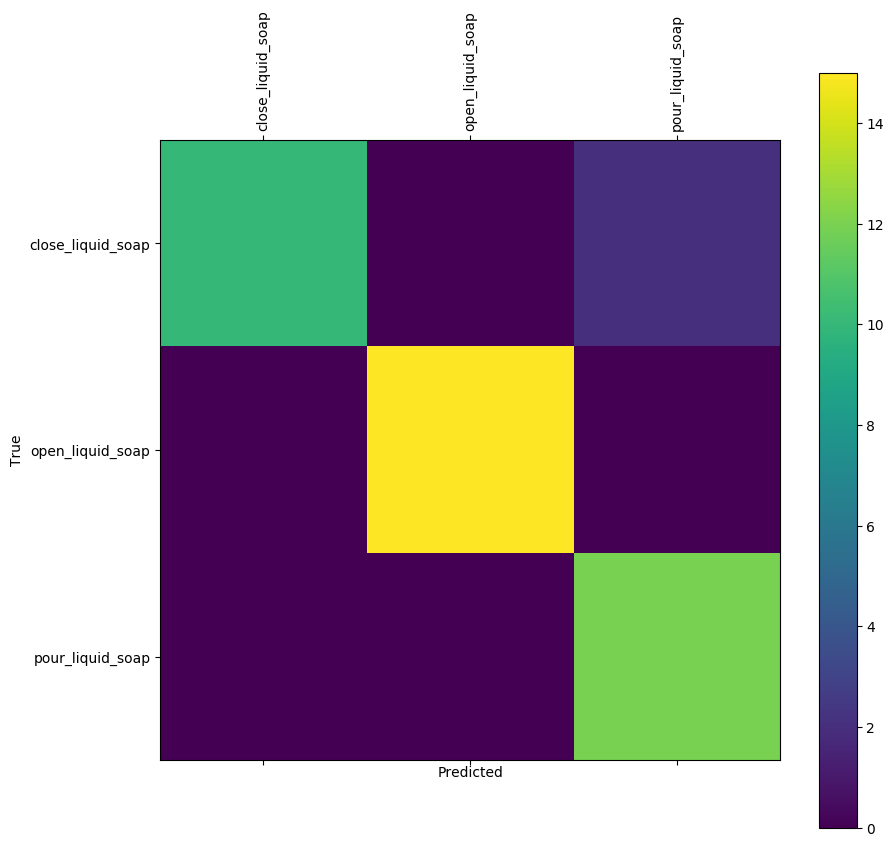

In [8]:
#Train subnets independently of group RNN 

#To visualise the whole grouping of 45 actions at once as a nested list
"""
for i in range(26):
    group_sub_labels = get_group_labels(i)
    print(group_sub_labels)
"""

#Subnets are just like the orginal RNN but with a selected number of training samples from training.txt and testing.txt

location = directory + 'labels/grouping_1/object_group_labels.txt'
(atog, g_labels) = action_to_group(location, family)

#do a for group_number in range(max(atog)+1):
group_number = 3 
num_classes = atog.count(group_number) #number of classes
group_sub_labels = get_group_labels(group_number) #labels of classes (inside this group)

if num_classes > 1: #don't train RNN with 1 output
    
    (labels, pred_labels, true_labels) = doMyRNN(location, family, group_number)

    #Evaluating subnet
    acc = np.mean(np.equal(true_labels, pred_labels))
    print('Group %i "%s" - %s - accuracy: %.2f %%' % (group_number, g_labels[group_number], group_sub_labels, float(100*acc)))
    print(pred_labels)
    print(true_labels)
    print(np.equal(true_labels, pred_labels))
    confusion_mtx(true_labels, pred_labels, group_sub_labels)
    

In [ ]:
#1. Train all subnets with a for loop and save them all
#2. Import each as pre-trained model
#3. Gather relevant output of groupRNN 
#4. Feed it to subnet
#5. # Get accuracy of each subnet and overall accuracy, including the outputs that did not get a subnet (1 action groups)

In [9]:
#Obtain all original data
(test_data, test_labels, test_lengths) = create_dataset(file_testing, [], -2)
test_data, test_labels, test_lengths = np.asarray(test_data), np.asarray(test_labels), np.asarray(test_lengths) 

#Link groupRNN output to subnets input using pred_labels
location = directory + 'results/group_RNN/' + family + '/'
pred_labels = np.load(location + 'pred_labels.npy') 
indices = [index for index, value in enumerate(pred_labels) if value == group_number]

#Start for loop here
(sub_test_data, sub_test_labels, sub_test_lengths) = test_data[indices], test_labels[indices], test_lengths[indices]
#use sub_test_labels to compare at the end


In [11]:
#Load pre-trained subnet
sess=tf.Session()    
location = directory + 'saved_sessions/subnets/' + family + '/subnet_' + str(group_number)
saver = tf.train.import_meta_graph(location + ".meta")
saver.restore(sess, location)
graph = tf.get_default_graph()

#Import variables
x = graph.get_tensor_by_name("x:0")
y = graph.get_tensor_by_name("y:0")
seqlen = graph.get_tensor_by_name("seqlen:0")
keep_prob = graph.get_tensor_by_name("keep_prob:0")
#Maybe weights need to be loaded and put into feed_dict.. check ???

#dont need to pass labels normally as they are not used
#one_hot the label as not done in create_dataset for this part
#sub_test_labels = np.asarray( num_to_idx(???num, ???num_classes) )
#if not true, add 'y' to feed_dict

feed_dict={x: sub_test_data, seqlen: sub_test_lengths, keep_prob: 1.0} 
prediction = graph.get_tensor_by_name("prediction:0")
#sub_pred_labels = prediction.eval(feed_dict)
sub_pred_labels = sess.run(prediction, feed_dict) 

print(sub_pred_labels)

INFO:tensorflow:Restoring parameters from /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/subnets/Object/subnet_3
[0 1 2 2 0 1 2 2 0 0 0 1 0 0 1 0 1 2 0 0 0 1 2 2 0 1 1 1 2 2 1 0]


In [14]:
gtoa = group_to_action(atog); list_actions = gtoa[group_number] 
original_sub_pred_labels = [list_actions[i] for i in sub_pred_labels]

print(sub_test_labels)
print(original_sub_pred_labels)

correct_pred = np.equal(original_sub_pred_labels, sub_test_labels) #output 0 & 1 vector
#append it to the rest of preds first...
#acc = np.mean(correct_pred) #mean of above

print(correct_pred)

#Only care about overall accuracy of the subnet after

[ 3 16 22 22 37 16 22 22 32  3  3 16  3  3  8 10 16 22  3 13 14 16 22 22
  3 16 16 16 22 22 23 37]
[3, 16, 22, 22, 3, 16, 22, 22, 3, 3, 3, 16, 3, 3, 16, 3, 16, 22, 3, 3, 3, 16, 22, 22, 3, 16, 16, 16, 22, 22, 16, 3]
[ True  True  True  True False  True  True  True False  True  True  True
  True  True False False  True  True  True False False  True  True  True
  True  True  True  True  True  True False False]


In [15]:
for i in range(26):
    group_sub_labels = get_group_labels(i)
    print(group_sub_labels)

['charge_cell_phone']
['clean_glasses', 'unfold_glasses']
['close_juice_bottle', 'open_juice_bottle', 'pour_juice_bottle']
['close_liquid_soap', 'open_liquid_soap', 'pour_liquid_soap']
['close_milk', 'open_milk', 'pour_milk']
['close_peanut_butter', 'open_peanut_butter']
['drink_mug']
['flip_pages']
['flip_sponge', 'scratch_sponge', 'squeeze_sponge', 'wash_sponge']
['give_card']
['give_coin', 'receive_coin']
['handshake', 'high_five']
['light_candle']
['open_letter', 'take_letter_from_enveloppe']
['open_soda_can']
['open_wallet']
['pour_wine']
['prick']
['put_salt']
['put_sugar', 'scoop_spoon', 'sprinkle', 'stir']
['put_tea_bag']
['read_letter', 'squeeze_paper', 'tear_paper']
['toast_wine']
['use_calculator']
['use_flash']
['write']
